# 벡터DB 데이터 저장 및 검색
- pinecone db 사용

In [5]:
from dotenv import load_dotenv
import os

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv(override=True)
PINECONE_API_KEY = os.environ['PINECONE_API_KEY']
# PINECONE_API_KEY

# pinecone 연결, index 객체 생성

In [6]:
from pinecone import Pinecone

#pinecone 객체생성
pc = Pinecone(api_key=PINECONE_API_KEY)

index_name = "embedding-test"

#index 객체 생성
index = pc.Index(index_name)

In [4]:
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '148',
                                    'content-type': 'application/json',
                                    'date': 'Mon, 29 Dec 2025 03:39:24 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '36',
                                    'x-pinecone-request-id': '8461613913241224539',
                                    'x-pinecone-request-latency-ms': '35',
                                    'x-pinecone-response-duration-ms': '38'}},
 'dimension': 3,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'storageFullness': 0.0,
 'total_vector_count': 0,
 'vector_type': 'dense'}

# 데이터 Upsert

## embedding vector 생성

In [8]:
vectors=[
        {
            "id": "vec1",
            "values": [1.0, 1.5, 2.0],  # 임베딩 벡터, 행벡터 3차원
            "metadata": {"genre": "drama"}  # 
        }, {
            "id": "vec2",
            "values": [2.0, 1.0, 0.5],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec3",
            "values": [0.1, 0.3, 0.5],
            "metadata": {"genre": "drama"}
        }, {
            "id": "vec4",
            "values": [1.0, 2.5, 3.5],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec5",
            "values": [3.0, 1.2, 1.3],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec6",
            "values": [0.3, 1.1, 2.5],
            "metadata": {"genre": "drama"}
        }
    ]

## 벡터 db(pinecone)에 저장

In [9]:
# namespace : default
index.upsert(vectors)

UpsertResponse(upserted_count=6, _response_info={'raw_headers': {'date': 'Mon, 29 Dec 2025 03:46:37 GMT', 'content-type': 'application/json', 'content-length': '19', 'connection': 'keep-alive', 'x-pinecone-request-lsn': '1', 'x-pinecone-request-logical-size': '207', 'x-pinecone-request-latency-ms': '250', 'x-pinecone-request-id': '192720066100969415', 'x-envoy-upstream-service-time': '251', 'x-pinecone-response-duration-ms': '252', 'grpc-status': '0', 'server': 'envoy'}})

In [10]:
#namespace="embedding-3d-ns1"에 저장
index.upsert(
    vectors,
    namespace="embedding-3d-ns1")

UpsertResponse(upserted_count=6, _response_info={'raw_headers': {'date': 'Mon, 29 Dec 2025 03:49:41 GMT', 'content-type': 'application/json', 'content-length': '19', 'connection': 'keep-alive', 'x-pinecone-request-lsn': '1', 'x-pinecone-request-logical-size': '207', 'x-pinecone-request-latency-ms': '247', 'x-pinecone-request-id': '291203115541352809', 'x-envoy-upstream-service-time': '248', 'x-pinecone-response-duration-ms': '249', 'grpc-status': '0', 'server': 'envoy'}})

# 쿼리(검색 : retrival)

In [15]:
# query_data = "코믹 영화 장르" => 임베딩 벡터로 만들기
response = index.query(
    namespace="embedding-3d-ns1",
    vector = [0.1, 0.3, 0.7],# 쿼리 벡터로 만들기
    top_k =3,# 검색 갯수
    include_values=True, # 벡터 데이터
    include_metadata=True, # 메타데이터 포함
)
print(response)

QueryResponse(matches=[{'id': 'vec6',
 'metadata': {'genre': 'drama'},
 'score': 1.00006485,
 'values': [0.3, 1.1, 2.5]}, {'id': 'vec3',
 'metadata': {'genre': 'drama'},
 'score': 0.990785182,
 'values': [0.1, 0.3, 0.5]}, {'id': 'vec4',
 'metadata': {'genre': 'action'},
 'score': 0.972905457,
 'values': [1.0, 2.5, 3.5]}], namespace='embedding-3d-ns1', usage={'read_units': 1}, _response_info={'raw_headers': {'date': 'Mon, 29 Dec 2025 05:15:52 GMT', 'content-type': 'application/json', 'content-length': '337', 'connection': 'keep-alive', 'x-pinecone-max-indexed-lsn': '1', 'x-pinecone-request-latency-ms': '98', 'x-pinecone-request-id': '8796367573854589718', 'x-envoy-upstream-service-time': '98', 'x-pinecone-response-duration-ms': '100', 'grpc-status': '0', 'server': 'envoy'}})


## 필터 조건 내에서 검색하기
- 검색을 할 때, 메타데이터 기반으로 필터링한 결과 내에서 top-k를 검색함

In [16]:
# query_data = "코믹 영화 장르" => 임베딩 벡터로 만들기
response = index.query(
    namespace="embedding-3d-ns1",
    vector = [0.1, 0.3, 0.7],# 쿼리 벡터로 만들기
    top_k =3,# 검색 갯수
    include_values=True, # 벡터 데이터
    include_metadata=True, # 메타데이터 포함
    filter={ # where 절과 유사함
        'genre' : {'$eq': 'drama'} 
    }
)
print(response)

QueryResponse(matches=[{'id': 'vec6',
 'metadata': {'genre': 'drama'},
 'score': 1.00006485,
 'values': [0.3, 1.1, 2.5]}, {'id': 'vec3',
 'metadata': {'genre': 'drama'},
 'score': 0.990785182,
 'values': [0.1, 0.3, 0.5]}, {'id': 'vec1',
 'metadata': {'genre': 'drama'},
 'score': 0.943127871,
 'values': [1.0, 1.5, 2.0]}], namespace='embedding-3d-ns1', usage={'read_units': 1}, _response_info={'raw_headers': {'date': 'Mon, 29 Dec 2025 05:22:57 GMT', 'content-type': 'application/json', 'content-length': '334', 'connection': 'keep-alive', 'x-pinecone-max-indexed-lsn': '1', 'x-pinecone-request-latency-ms': '85', 'x-pinecone-request-id': '3289505407565248485', 'x-envoy-upstream-service-time': '85', 'x-pinecone-response-duration-ms': '87', 'grpc-status': '0', 'server': 'envoy'}})


In [20]:
index_data = index.list(
    namespace = "embedding-3d-ns1"
)

In [21]:
list(index_data)[0]

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']

# Embedding Vector space 시각화 하기

In [22]:
# 지정된 네임스페이스(embedding-3d-ns1)에 있는 모든 ID를 리스트 형태로 반환합니다.
for ids in index.list(namespace="embedding-3d-ns1"):
    # 주어진 ID와 네임스페이스에 해당하는 벡터 데이터를 가져옵니다.
    # 반환된 데이터는 딕셔너리 형태이며, 
    # 그 중에서 'vectors' 키에 해당하는 값을 vectors 변수에 저장합니다.
    # vectors = index.fetch(ids, namespace="embedding-3d-ns1")
    # print(vectors)
    vectors = index.fetch(ids, namespace="embedding-3d-ns1")['vectors']

print(vectors.values())

dict_values([Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None), Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None), Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None), Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None), Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None), Vector(id='vec2', values=[2.0, 1.0, 0.5], metadata={'genre': 'action'}, sparse_values=None)])


In [23]:
# ids: 벡터 데이터에서 추출한 ID 리스트.
# values: 벡터 데이터에서 추출한 값 리스트.
ids = [v['id'] for v in vectors.values()]
values = [v['values'] for v in vectors.values()]

ids += ["qv"]
values += [[0.1, 0.3, 0.7]]

print(ids)
print(values)

['vec1', 'vec5', 'vec4', 'vec3', 'vec6', 'vec2', 'qv']
[[1.0, 1.5, 2.0], [3.0, 1.2, 1.3], [1.0, 2.5, 3.5], [0.1, 0.3, 0.5], [0.3, 1.1, 2.5], [2.0, 1.0, 0.5], [0.1, 0.3, 0.7]]


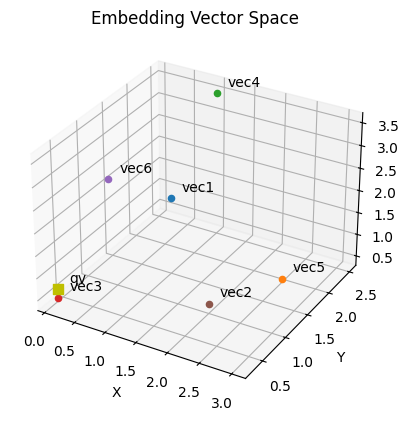

In [24]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()